In [245]:
import matplotlib
import bokeh
import plotly
import sklearn

In [246]:
import os
import findspark

if os.path.isdir("/cluster/home/simondi/spark/"):
    is_cluster = True
    import sparkhpc
    from sparkhpc import sparkjob
    spark_path = "/cluster/home/simondi/spark/"
else:
    is_cluster = False
    spark_path = "/usr/local/spark/spark/"

findspark.init(spark_path)
import pyspark

In [247]:
from pyspark.rdd import reduce
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler

In [248]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import SparseVector, VectorUDT, Vector

In [249]:
conf = pyspark.SparkConf().setAppName("asd").setMaster("local[*]").set('spark.executor.memory', '42').set('spark.driver.memory', '2G')
sc = pyspark.SparkContext(conf=conf)

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=App Name, master=local) created by __init__ at <ipython-input-6-ee6314122013>:1 

In [250]:
spark = pyspark.sql.SparkSession(sc)

In [251]:
if is_cluster:
    file_name = "/cluster/home/simondi/simondi/tix/data/screening_data/cells_sample_10.tsv"
else:
    file_name = "/Users/simondi/PHD/data/data/target_infect_x/screening_data_subset/cells_sample_10.tsv"

In [252]:
df = spark.read.csv(path=file_name, sep="\t", header='true')

In [253]:
df.cache()

DataFrame[study: string, pathogen: string, library: string, design: string, replicate: string, plate: string, well: string, gene: string, sirna: string, well_type: string, image_idx: string, object_idx: string, cells.areashape_area: string, cells.areashape_eccentricity: string, cells.areashape_extent: string, cells.areashape_formfactor: string, cells.areashape_majoraxislength: string, cells.areashape_minoraxislength: string, cells.areashape_perimeter: string, cells.children_bacteria_count: string, cells.children_invasomes_count: string, cells.location_center_x: string, cells.location_center_y: string, cells.neighbors_anglebetweenneighbors_2: string, cells.neighbors_firstclosestobjectnumber_2: string, cells.neighbors_firstclosestxvector_2: string, cells.neighbors_firstclosestyvector_2: string, cells.neighbors_numberofneighbors_2: string, cells.neighbors_secondclosestobjectnumber_2: string, cells.neighbors_secondclosestxvector_2: string, cells.neighbors_secondclosestyvector_2: string, ce

In [254]:
old_cols = df.schema.names
new_cols = list(map(lambda x: x.replace(".", "_"),  old_cols))
df = reduce(lambda data, idx: data.withColumnRenamed(old_cols[idx], new_cols[idx]), range(len(new_cols)), df)
for i, x in enumerate(new_cols):
    if x.startswith("cells"):
        df= df.withColumn(x, df[x].cast("double"))

In [255]:
assembler = VectorAssembler(inputCols=[x for x in new_cols if x.startswith("cells")], outputCol='features')

In [256]:
X = assembler.transform(df)

In [257]:
X.count()

5713106

In [ ]:
Y = X.sample(fraction=.5, withReplacement=False).take(10000)

In [ ]:
Y.count()

In [ ]:
path_count = Y.select("pathogen").distinct().count()
path_count

In [264]:
kmeans = KMeans(k=5, seed=23)
model = kmeans.fit(X)

Py4JError: An error occurred while calling o2647.sample. Trace:
py4j.Py4JException: Method sample([class java.lang.Boolean, class java.lang.Integer, class java.lang.Integer]) does not exist
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:318)
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:326)
	at py4j.Gateway.invoke(Gateway.java:272)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)



In [222]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors

In [223]:
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
pca_model = pca.fit(Y)

In [224]:
result = pca_model.transform(Y).select("pcaFeatures")

In [225]:
df2 = result.rdd.map(lambda x: tuple(float(x)  for x in x.pcaFeatures.values )).toDF()
df2  = df2.withColumnRenamed("_1", "PCA1")
df2  = df2.withColumnRenamed("_2", "PCA2")

In [226]:
df2 = df2.toPandas()

In [227]:
df2[1:5]

,PCA1,PCA2
1,-2493.784385,-893.490353
2,-4659.113992,-1072.669199
3,-4080.730877,-1071.328571
4,-4042.287995,-1223.411457


In [228]:
df2["pathogen"] = Y.select("pathogen").toPandas()
df2["design"] = Y.select("design").toPandas()
df2["library"] = Y.select("library").toPandas()

In [229]:
df2[1:5]

,PCA1,PCA2,pathogen,design,library
1,-2493.784385,-893.490353,listeria,u,a
2,-4659.113992,-1072.669199,listeria,u,a
3,-4080.730877,-1071.328571,listeria,u,a
4,-4042.287995,-1223.411457,listeria,u,a


In [230]:
groups = df2.groupby(['pathogen'])

u


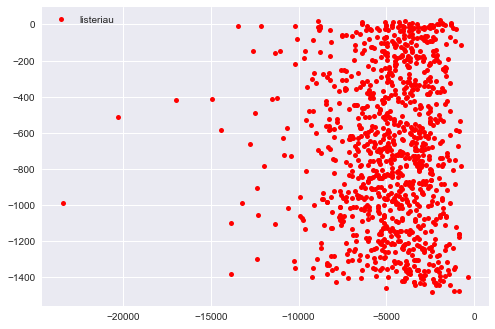

In [231]:
from cycler import cycler


fig, ax = matplotlib.pyplot.subplots()
matplotlib.pyplot.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y'])))
ax.margins(0.05)
for name, group in groups:
    design_groups = group.groupby(['design'])
    for design, dgr in design_groups:
        print(design)
        ax.plot(dgr.PCA1, dgr.PCA2, marker='o', linestyle='', ms=5, label=name +", "+ design)
ax.legend()
matplotlib.pyplot.show()